#  Recommendation System for Netflix Prize Dataset using SVD

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

dataset = pd.read_csv(
    'combined_data_1.txt',
    header=None,
    names=['Cust_Id', 'Rating', 'Date'],
    engine='python',
    encoding='latin1',
    on_bad_lines='skip'                  # Optional: skip broken lines
)

dataset.head()


Cust_Id  Rating        Date
0       1:     NaN        None
1  1488844     3.0  2005-09-06
2   822109     5.0  2005-05-13
3   885013     4.0  2005-10-19
4    30878     4.0  2005-12-26

In [3]:
dataset=dataset.drop('Date',axis=1)

In [4]:
#To print the datatype of columns
dataset.dtypes

Cust_Id     object
Rating     float64
dtype: object

In [5]:
#To inspect the shape of the datset
dataset.shape

(24058263, 2)

In [6]:
#To find the distribution of different ratings in the datset
p=dataset.groupby('Rating')['Rating'].agg(['count'])
p

count
Rating         
1.0     1118186
2.0     2439073
3.0     6904181
4.0     8085741
5.0     5506583

In [7]:
# get movie count by counting nan values
movie_count=dataset.isnull().sum()[1]
movie_count
#4499 total number of movies present in dataset

/tmp/ipython-input-7-3335535533.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie_count=dataset.isnull().sum()[1]


4499

In [8]:
# get customer count
cust_count=dataset['Cust_Id'].nunique()-movie_count
cust_count

470758

In [9]:
# get rating count
rating_count=dataset['Rating'].count()
rating_count

24053764

# To plot the distribution of the ratings in as a bar plot

Text(0.5, 1.0, 'Total pool:4499 Movies,470758customers, 24053764 ratings given')

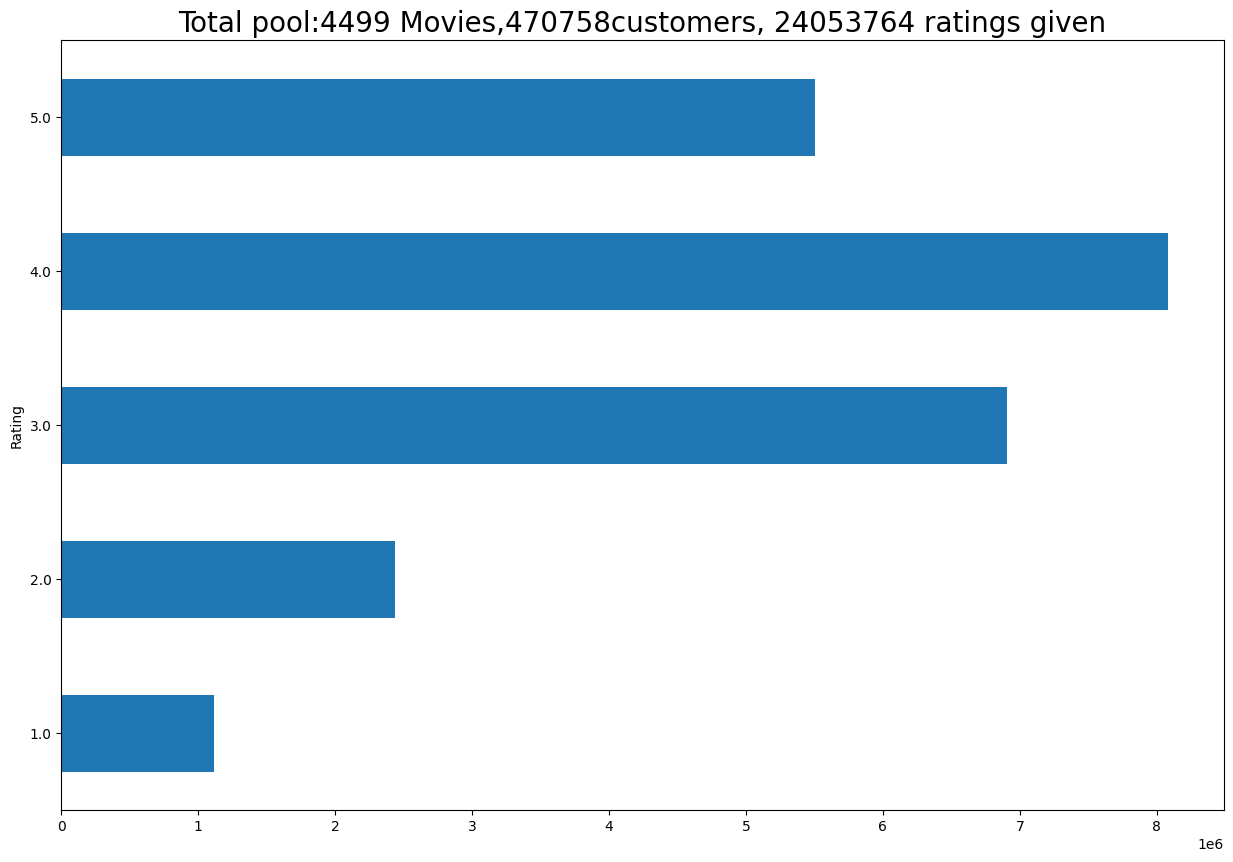

In [10]:
ax=p.plot(kind='barh',legend=False,figsize=(15,10))
plt.title(f'Total pool:{movie_count} Movies,{cust_count}customers, {rating_count} ratings given', fontsize=20)
#plt.axis('off')


#print--->print data  '' 'Total pool'

# To create a numpy array containing movie ids corresponding to the rows in the 'ratings' dataset

In [11]:
# To count all the 'nan' values in the Ratings column in the 'ratings' dataset
df_nan=pd.DataFrame(pd.isnull(dataset.Rating))
df_nan.head()

Rating
0    True
1   False
2   False
3   False
4   False

In [12]:
# To store the index of all the rows containing 'nan' values
df_nan=df_nan[df_nan['Rating']==True]
df_nan.shape

(4499, 1)

In [13]:
# To reset the index of the dataframe
df_nan=df_nan.reset_index()
df_nan.head()

index  Rating
0      0    True
1    548    True
2    694    True
3   2707    True
4   2850    True

In [14]:
#To create a numpy array containing movie ids according the 'ratings' dataset
movie_np=[]
movie_id=1
#into tuple
for i ,j in zip(df_nan['index'][1:],df_nan['index'][:-1]):
    temp=np.full((1,i-j-1),movie_id)
    movie_np=np.append(movie_np,temp)
    movie_id+=1
# Account for last record and corresponding length
last_record=np.full((1,len(dataset)-df_nan.iloc[-1,0]-1),movie_id)
movie_np = np.append(movie_np, last_record)

print(f'Movie numpy: {movie_np}')
print(f'Length: {len(movie_np)}')

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [15]:
#To append the above created array to the datset after removing the 'nan' rows
dataset=dataset[pd.notnull(dataset['Rating'])]# movies count so nan
dataset['Movie_Id']=movie_np.astype(int)
dataset['Cust_Id']=dataset['Cust_Id'].astype(int)
dataset.head()

Cust_Id  Rating  Movie_Id
1  1488844     3.0         1
2   822109     5.0         1
3   885013     4.0         1
4    30878     4.0         1
5   823519     3.0         1

In [16]:
dataset.shape

(24053764, 3)

# Data Cleaning

In [17]:
f = ['count','mean']
#count and mean


In [18]:
#To create a list of all the movies rated less often(only include top 30% rated movies)
dataset_movie_summary = dataset.groupby('Movie_Id')['Rating'].agg(f)

dataset_movie_summary.index = dataset_movie_summary.index.map(int)

movie_benchmark = round(dataset_movie_summary['count'].quantile(0.7),0)

drop_movie_list = dataset_movie_summary[dataset_movie_summary['count'] < movie_benchmark].index

print('Movie minimum times of review: {}'.format(movie_benchmark))

Movie minimum times of review: 1799.0


In [19]:
#To create a list of all the inactive users(users who rate less often)
dataset_cust_summary=dataset.groupby('Cust_Id')['Rating'].agg(f)
dataset_cust_summary.index=dataset_cust_summary.index.map(int)
cust_benchmark=round(dataset_cust_summary['count'].quantile(0.7),0)
drop_cust_list=dataset_cust_summary[dataset_cust_summary['count']<cust_benchmark].index
print(f'Customer minimum times of review:{cust_benchmark}')

Customer minimum times of review:52.0


In [20]:
print(f'Original Shape: {dataset.shape}')

Original Shape: (24053764, 3)


In [21]:
dataset=dataset[~dataset['Movie_Id'].isin(drop_movie_list)]
#in dataset --->in all movie ids------>if the whic ever  movies we put under drop list are present or not---
#if present drop /remove them
dataset=dataset[~dataset['Cust_Id'].isin(drop_cust_list)]
#removing all inactive users from our dataset
print('After Trim Shape: {}'.format(dataset.shape))

After Trim Shape: (17337458, 3)


In [22]:

print('-Data Examples-')
dataset.head()

-Data Examples-


Cust_Id  Rating  Movie_Id
696   712664     5.0         3
697  1331154     4.0         3
698  2632461     3.0         3
699    44937     5.0         3
700   656399     4.0         3

In [23]:
# Create rating matrix for 'rating ' matrix with Rows = userid,columns=movieid
df_p=pd.pivot_table(dataset,values='Rating',index='Cust_Id',columns='Movie_Id')
print(df_p.shape)

(143458, 1350)


In [24]:
df_p.head()

Movie_Id  3     8     16    17    18    26    28    30    32    33    ...  \
Cust_Id                                                               ...   
6          NaN   NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN   NaN  ...   
7          NaN   5.0   NaN   NaN   NaN   NaN   4.0   5.0   NaN   NaN  ...   
79         NaN   NaN   NaN   NaN   NaN   NaN   NaN   3.0   NaN   NaN  ...   
97         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
134        NaN   NaN   NaN   NaN   NaN   NaN   5.0   NaN   NaN   NaN  ...   

Movie_Id  4472  4474  4478  4479  4485  4488  4490  4492  4493  4496  
Cust_Id                                                               
6          3.0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
7          3.0   NaN   NaN   5.0   NaN   NaN   NaN   NaN   NaN   NaN  
79         4.0   NaN   NaN   NaN   NaN   NaN   4.0   NaN   NaN   NaN  
97         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
134        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[5 rows x 1350 columns]

# To load the movie_title dataset

In [25]:
df_title = pd.read_csv(
    'movie_titles (1).csv',
    encoding='latin1',
    header=None,
    names=['Movie_Id', 'Year', 'Name'],
    on_bad_lines='skip'
)
df_title.set_index('Movie_Id', inplace=True)
print (df_title.head(10))

            Year                          Name
Movie_Id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


# To install the scikit -superise libary for implementing SVD

In [26]:
!pip install scikit-surprise


In [27]:
# import required libaries
import math
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [28]:
# Downgrade NumPy to version < 2
!pip install numpy==1.24.4 --quiet


In [29]:
#load Reader Library
reader=Reader()

#get just top 100k rows for faster  run time
data=Dataset.load_from_df(dataset[['Cust_Id','Movie_Id','Rating']][:100000],reader)

# use the SVD algorithm
svd=SVD()

#compute the RMSE of the SVD algorithm
cross_validate(svd,data,measures=['RMSE','MAE'])

{'test_rmse': array([0.99500758, 0.99354935, 0.99517822, 0.99884389, 1.00252287]),
 'test_mae': array([0.79313947, 0.78978436, 0.79269055, 0.79844648, 0.8042935 ]),
 'fit_time': (2.4743165969848633,
  2.0500130653381348,
  1.7687022686004639,
  1.7718958854675293,
  1.7959489822387695),
 'test_time': (0.15102052688598633,
  0.23134565353393555,
  0.1158132553100586,
  0.10538387298583984,
  0.10203051567077637)}

In [30]:
dataset.head()

Cust_Id  Rating  Movie_Id
696   712664     5.0         3
697  1331154     4.0         3
698  2632461     3.0         3
699    44937     5.0         3
700   656399     4.0         3

# To find all the movies rated as 5 starsby user with userid = 712664

In [32]:
dataset_712664=dataset[(dataset['Cust_Id']==712664)&(dataset['Rating']==5)]
dataset_712664=dataset_712664.set_index('Movie_Id')
dataset_712664=dataset_712664.join(df_title)['Name']
dataset_712664.head(10)

Movie_Id
3                              Character
79                           The Killing
175                       Reservoir Dogs
199                      The Deer Hunter
241                   North by Northwest
256    Ghost Dog: The Way of the Samurai
348        The Last Temptation of Christ
357                House of Sand and Fog
416                             Elephant
442                  Mississippi Burning
Name: Name, dtype: object

# Train an SVD to predict rating for user with userid=1

In [34]:
# create a shallow copy for the movies dataset
user_712664=df_title.copy()

user_712664=user_712664.reset_index()

user_712664=user_712664[~user_712664['Movie_Id'].isin(drop_movie_list)]

# getting full dataset
data=Dataset.load_from_df(dataset[['Cust_Id','Movie_Id','Rating']],reader)

#create a training set for svd
trainset=data.build_full_trainset()
svd.fit(trainset)

# predict the rating for users_712664
user_712664['Estimate_Score']=user_712664['Movie_Id'].apply(lambda x:svd.predict(712664,x).est)

# drop extra columns from the user_712664 in descending order
user_712664=user_712664.sort_values('Estimate_Score',ascending=False)


#Print top 10 recommendations
print(user_712664.head(10))

      Movie_Id    Year                               Name  Estimate_Score
221        223  2003.0         Chappelle's Show: Season 1             5.0
2990      3046  1990.0  The Simpsons: Treehouse of Horror             5.0
4038      4115  1999.0            The Simpsons: Bart Wars             5.0
2136      2172  1991.0             The Simpsons: Season 3             5.0
857        872  1954.0                      Seven Samurai             5.0
173        175  1992.0                     Reservoir Dogs             5.0
762        774  2003.0                 Foyle's War: Set 2             5.0
2067      2102  1994.0             The Simpsons: Season 6             5.0
999       1020  1989.0             The Simpsons: Season 1             5.0
4270      4353  2002.0     Curb Your Enthusiasm: Season 3             5.0
